In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Dallas points onto the street network

Explore how the longitude/latitude coordinates in the Dallas dataset match up to the street network.

Answer: Very Well

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, lzma
import open_cp.geometry
open_cp.geometry.configure_gdal()
import pyproj
proj = pyproj.Proj({"init":"EPSG:2845"})

import impute.tiger_lines
import impute.dallas
import impute.voroni

In [35]:
datadir = os.path.join("..", "..", "..", "..", "Data")
tigerdir = os.path.join(datadir, "TIGER Data")

In [4]:
streets = impute.tiger_lines.TigerLines(
    os.path.join(tigerdir, "tl_2016_48113_roads__dallas_county"),
    os.path.join(tigerdir, "tl_2016_48113_edges__dallas_county"),
    proj)

In [5]:
filename = os.path.join(datadir, "Dallas_11_Sept_2017.csv.xz")
with lzma.open(filename, "rt") as file:
    data = [row for row in impute.dallas.load_full(file)
            if row.lonlat is not None and row.xy is not None]
len(data), data[0]

(123322,
 Row(code='276285-2016', crime_type='BURGLARY', crime_subtype='BURGLARY-RESIDENCE', start_time=datetime.datetime(2016, 11, 16, 11, 0), end_time=datetime.datetime(2016, 11, 18, 11, 0), call_time=datetime.datetime(2016, 11, 18, 11, 42, 26), address='5850 BELT LINE RD', city='DALLAS 75254', lonlat=(-96.807131, 32.953948), xy=(758206.7262484236, 2144003.9338816064)))

In [6]:
graph, edge_list = streets.make_reduced_graph()

In [7]:
segments = list(open_cp.network.segment_graph(graph))

# Project points to street network

In [8]:
row = data[32]
row

Row(code='276019-2015', crime_type='THEFT', crime_subtype='THEFT/BMV', start_time=datetime.datetime(2015, 11, 27, 14, 0), end_time=datetime.datetime(2015, 11, 27, 14, 1), call_time=datetime.datetime(2015, 11, 27, 14, 4, 13), address='1000 ROSS AVE', city='DALLAS 75202', lonlat=(-96.804652, 32.782395), xy=(758807.9029683657, 2124985.733644078))

In [9]:
x,y = proj(*row.lonlat)

edge, t = graph.project_point_to_graph(x, y)
edge, t

((258223, 258218), 0.11018072371517347)

In [10]:
edge_index, _ = graph.find_edge(*edge)
edge_index

222907

In [11]:
names = streets.merged_names[ edge_list[edge_index] ]
names

(edge_noline(fullname='Ross Ave', left_address_from='1001', left_address_to='1099', right_address_from='1000', right_address_to='1098'),
 {'Ross Ave'})

In [12]:
a = names[0]
for i, (b, _) in enumerate(streets.merged_names):
    if a == b:
        print(i, b)

319728 edge_noline(fullname='Ross Ave', left_address_from='1001', left_address_to='1099', right_address_from='1000', right_address_to='1098')


In [13]:
for seg in segments:
    if edge_index in seg:
        for idx in seg:
            i = edge_list[idx]
            print(i, streets.merged_names[i])

244512 (edge_noline(fullname='Ross Ave', left_address_from='901', left_address_to='999', right_address_from='900', right_address_to='998'), {'Ross Ave'})
244513 (edge_noline(fullname='Ross Ave', left_address_from='901', left_address_to='999', right_address_from='900', right_address_to='998'), {'Ross Ave'})
319728 (edge_noline(fullname='Ross Ave', left_address_from='1001', left_address_to='1099', right_address_from='1000', right_address_to='1098'), {'Ross Ave'})


Maybe merge along "segments" in the reduced graph (again...)

Looks promising...

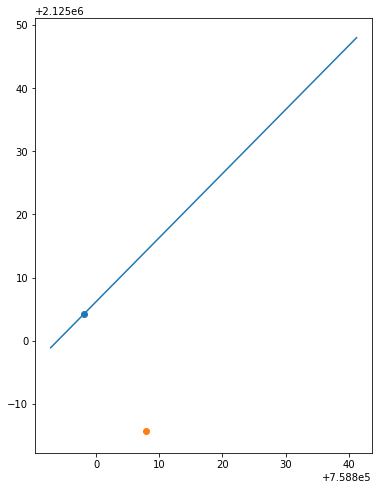

In [14]:
fig, ax = plt.subplots(figsize=(8,8))

for seg in segments:
    if edge_index in seg:
        v1, v2 = graph.edges[edge_index]
        x1, y1 = graph.vertices[v1]
        x2, y2 = graph.vertices[v2]
        ax.plot([x1,x2], [y1,y2])
        
ax.scatter(x,y)
ax.scatter(*row.xy)
ax.set_aspect(1)

So we get a map from `xy` (orange dot) to the line.

Then, for "new" `xy` coords, want to pick the "most likely" line...

## Voroni again

We form a voroni diagram around the `xy` points.  Use a "redistributor" as it supports fast finding of containing polygons.

In [26]:
moved_points = np.asarray([row.xy for row in data])
voroni = impute.voroni.Voroni(moved_points)
redist = voroni.to_redistributor(None)

In [33]:
redist.find_containing_polygon(*moved_points[0])

[28156]

So the complete procedure is this:

- Look at each point where we have both a lon/lat coordinate, and an `xy` coordinate.
- Find the "segment" of the street network graph which the lon/lat coordinate falls in
- Partition space into Voroni cells from the `xy` coordinate
- Our map then takes the interior of the Voroni cell to the segment of the graph.

# Can we detect errors?

How much is the jump between the two coordinates?

In [38]:
distances = []
for row in data:
    x, y = proj(*row.lonlat)
    xx, yy = row.xy
    distances.append(np.sqrt((x-xx)**2 + (y-yy)**2))
    
distances = np.sort(distances)

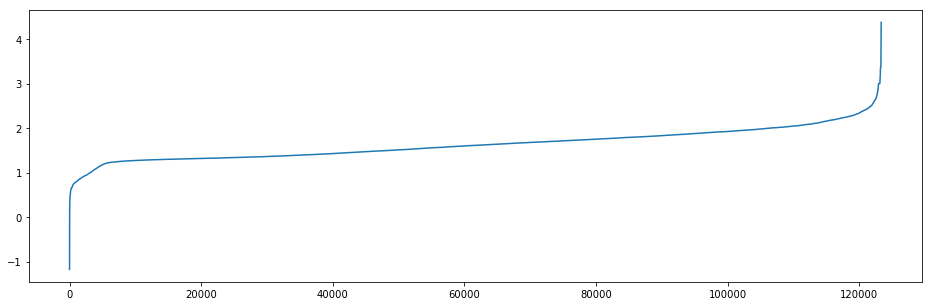

In [41]:
fig, ax = plt.subplots(figsize=(16,5))

ax.plot(np.log10(distances))

In [44]:
np.sum(x>250 for x in distances) / len(distances) * 100

2.1577658487536691